In [5]:



## TODO
#
# separate generators for different input data
# CNN predict method
# PSPNet pyramyde_feature_map change from colors to list of blocks ( concatinate(list) )
# comprassion inputs of backbones and decoders
#
##

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Dataset
## https://www.kaggle.com/dansbecker/cityscapes-image-pairs

In [2]:
# from PSPnet import PSPNet
#
# pspnet = PSPNet(input_size=(192, 192, 3), pretrained_model='best_psp_model.h5', efnet=True)
# pspnet.compile()

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
ERROR: SIZE IS WRONG
ERROR: SIZE IS WRONG
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 192, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 192, 192, 32) 0           batch_normalization[0][0]        
____

In [1]:
import cv2
import numpy as np
import os

from EfficientNet import EfficientNet

efnet = EfficientNet(input_size=(None, None, 3))


from Unet import Unet

unet = Unet(input_size=(None, None, 3), output_channels=3, n_classes=1, backbone=efnet)
unet.compile()

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
elu (ELU)                       (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________

In [11]:
train_folder="train/"
valid_folder="val/"
#crating dataset
def get_images_masks(path):
    #list of files
    names=os.listdir(path)
    total = len(names)
    cur = 0
    #lists for images and masks
    img_g,img_m=[],[]
    #for all files
    for name in names[:]:
        #open image
        img=cv2.imread(path+name)
        #norm image in range [0, 1]
        img=cv2.normalize(img,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
        #to rgb
        img=img[:,:,::-1]
        #first half of image
        img_g.append(img[:, :256, :])
        #second half of image
        img_m.append(img[:, 256:, :])
        #delete image
        del img
        cur += 1
        print(f'{round(cur * 100 / total)}%', end='\r')
    print()    
    #delete list
    del names
    #transform to np format
    return np.array(img_g), np.array(img_m)

#create train data
train_imgs,train_masks=get_images_masks(train_folder)
#create valid data
valid_imgs,valid_masks=get_images_masks(valid_folder)

100%
100%


In [12]:
x_train = unet.createDataset(train_imgs)
y_train = unet.createDataset(train_masks)
x_valid = unet.createDataset(valid_imgs)
y_valid = unet.createDataset(valid_masks)

In [14]:
# x_train = pspnet.createDataset(train_imgs)
# y_train = pspnet.createDataset(train_masks)
# x_valid = pspnet.createDataset(valid_imgs)
# y_valid = pspnet.createDataset(valid_masks)

100%
100%
100%
100%


(192, 192)
(192, 192)


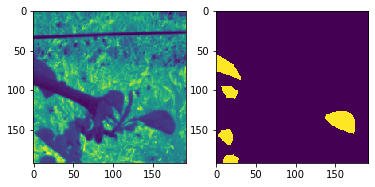

In [2]:
# from DataGenerator import Dataset, get_training_augmentation
# import matplotlib.pyplot as plt
#
# train_folder_x="common_dataset/x_train"
# train_folder_y="common_dataset/y_train"
#
# dataset = Dataset(train_folder_x, train_folder_y, crop_size=192, augmentation=get_training_augmentation(192), in_one_file=False)
#
#
# image, masl = dataset[0]
# print(image.shape)
# print(masl.shape)
# plt.subplot(121)
# plt.imshow(image)
# plt.subplot(122)
# plt.imshow(masl)


Epoch 1/10
372/372 [==============================] - 73s 197ms/step - loss: 0.0195 - iou_score: 0.2589 - val_loss: 0.0196 - val_iou_score: 0.2657

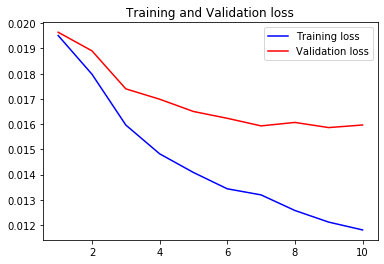

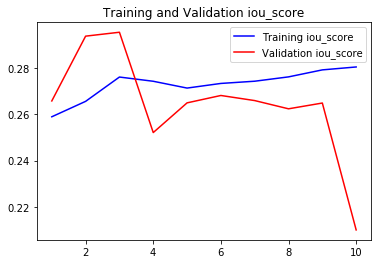

In [13]:
unet.fit(x_train, y_train, (x_valid, y_valid), BS=8, EPOCHS=10)

unet.show_graphs()

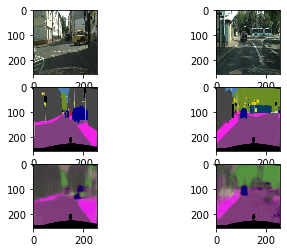

In [14]:
import matplotlib.pyplot as plt
#predict first 2 images
y = unet.model.predict(x_valid[0:2])

plt.subplot(321)
plt.imshow(x_valid[0])
plt.subplot(323)
plt.imshow(y_valid[0])
plt.subplot(325)
plt.imshow(y[0])
plt.subplot(322)
plt.imshow(x_valid[1])
plt.subplot(324)
plt.imshow(y_valid[1])
plt.subplot(326)
plt.imshow(y[1])


In [2]:
from DataGeneratorRGB import Dataset, Dataloder
from DataGeneratorRGB import get_training_augmentation, get_validation_augmentation

train_folder="train/"
valid_folder="val/"

train_dataset = Dataset(
    train_folder,
    augmentation=get_training_augmentation(256)
)

# Dataset for validation images
valid_dataset = Dataset(
    valid_folder,
    augmentation=get_validation_augmentation(256)
)

train_dataloader = Dataloder(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

Epoch 1/10
185/185 [==============================] - 70s 379ms/step - loss: 0.0438 - iou_score: 0.2265 - val_loss: 0.0480 - val_iou_score: 0.0965

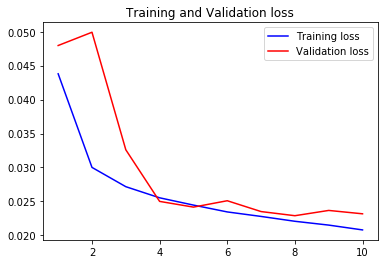

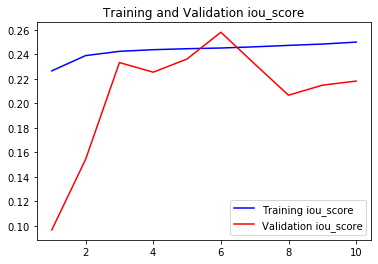

In [3]:
unet.fit(x_train=train_dataloader, valid_data=valid_dataloader, EPOCHS=10)

unet.show_graphs()

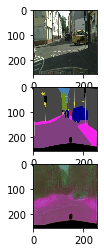

In [6]:
import matplotlib.pyplot as plt
#predict first 2 images
image, mask = valid_dataset[0]

y = unet.model.predict(np.array([image]))

plt.subplot(321)
plt.imshow(image)
plt.subplot(323)
plt.imshow(mask)
plt.subplot(325)
plt.imshow(y[0])
plt.show()